# Automated Discovery of Temperature Dependent Structural Change

    Neutron powder diffraction is a powerful way to examine the atomic structure of technologically interesting materials. The particular material from this data set is a candidate for solar cells . Nevertheless, the same methods are used in battery materials, catalysts, etc. A single data set has 2 dimensions: Intensity(I) and d spacing (d). The d spacing is a characteristic structural scale in the system. If there is a large I at a given d, that means there are at least two atoms spaced at that distance in the system. If I is at the background it means there is nothing with that d spacing in the material.
    
    Often functional behavior is related to a structural change with an external parameter like temperature. This structural change show up as change in the existence, position or width of the peaks. The provided data set is a collection of I vs d curves at multiple temperatures. So the data set is 3 dimensional I(d,T). The data is in an HDF5 file. H5py is a useful set of libraries for accessing HDF5 files from python. If you are not familiar with hdf5 and want to browse the data structure want to browse the data structure we recommend hdfview or nexpy. However, the developed algorithms should run independently of these codes.

# Challenge
    Given the aforementioned data set, here are the challenge questions
    
    1. Provide an algorithm that given the data set as an input, provides the temperature of the structural transition.
    2. Provide an algorithm that gives the integrated area under, the center of intensity, and a characteristic width for the peak that is between 3.2 and 3.3 Å in d spacing as a function of temperature.
    3. Provide an algorithm that gives the integrated area under, the center of intensity, and a characteristic width for all peaks at a given Temperature.
    4. Given adjacent temperatures, provide an algorithm that indicates if a phase transition occurred between the two temperatures, a list of centers, widths, and intensities for all peaks in the data set that are at least 1.5x above background in under 5 seconds

    Our preference is for the algorithms to be implemented in Python with use of the numpy library, other necessary libraries are welcome. If the participant prefers a compiled code, C/C++, is our preferred solution with the output being in a python or numpy data structure.

In [1]:
import numpy as np
import scipy as sp

#import h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
#%matplotlib notebook
%matplotlib inline
mpl.rcParams['savefig.dpi'] = 300

from nexusformat.nexus import *
import warnings
warnings.filterwarnings('ignore')

from IPython.core.pylabtools import figsize
np.set_printoptions(precision=3)

from matplotlib import rc
rc('text', usetex=True)

import os
os.makedirs('Q4/Data/', exist_ok=True)
os.makedirs('Q4/Figs/', exist_ok=True)

# Q0. Load the data, and convert the data into np arrays. 

In [2]:
ff = nxload('NPD_Temp.nxs')
data = ff.entry.data

'''to keep the nexus format. The data format are slightly difffernt to np array.'''
#_intsy = data['intensity']
#_QQs = data['Q']
#_dds = data['dspacing']
#_temps = data['temperature']

'''convert to numpy array'''
intsy = np.asarray(data['intensity'])
QQs = np.asarray(data['Q'])
dds = np.asarray(data['dspacing'])
temps = np.asarray(data['temperature'])
dd_cs = (dds[:-1]+dds[1:])/2
temp_cs = (temps[:-1]+ temps[1:])/2


# Q4 Given adjacent temperatures, provide an algorithm that indicates if a phase transition occurred between the two temperatures, a list of centers, widths, and intensities for all peaks in the data set that are at least 1.5x above background in under 5 seconds.

## 4.1 Using peak positions to determine the similarity between two datasets and calcuate the likehood of a phase transtion between these two temperatures. 


## 4.1. 1  calculate the distance between two peak tables at the two temperatures.

In [3]:
from numba import jit

@jit
def _ricker_asy(points, a):
    """
    A modified ricker wavelet based on the powder diffraction peak shape. 
    """
    alpha = 0.8
    
    A = 0.5 / (a  * (np.pi**0.5))
    wsq = a**2
    
    vec = np.arange(0, points) - (points - 1.0) / 2
    vec[np.int(points/2):] *=-alpha
    xsq = vec**2
    vec_oa = vec/a 
    
    mod = (1 - xsq / wsq)
    gauss = np.exp(-xsq / (2 * wsq))
    total = A * mod * gauss
    return total

#@jit
def find_peaks_flow(IntsyMap, pars, bin_cs, par_val=0, sep = 1/4., min_dis=2, 
                    wavelet=_ricker_asy, bkg=0):
    '''
    If a non-zero background term (float) is given, then it assumes that background is 
    predetermined and a background-removed dataset is given. the given value will be 
    the cutoff value.
    
    Otherwise it use 50 percentile value as the background limit. A cutoff value will 
    be calcualted. 
    '''
    from scipy.optimize import least_squares
    
    data = intsy[ (abs(pars - par_val)).argmin()].flatten()
    peakindx = _find_peaks_byindx(data, sep=sep, min_dis=min_dis, wavelet=wavelet) 
    
    if(bkg != 0):
        Bkg = []
        cutoff = bkg
    else:
        Bkg = [np.percentile(data, 50)]
        #cutoff = np.percentile(data, 50) + data[data<np.percentile(data, 50)].std()
        cutoff = data[data<np.percentile(data, 50)].std() * 3
    
    par_ini, bounds= Ini_Mpeaks_pars(data, peakindx, bin_cs, Bkg=Bkg)
    fit = least_squares(Mpeaks_LS, par_ini, bounds=bounds, 
                        args=(data, peakindx, bin_cs, len(Bkg)))
    model = Mpeaks_model(fit.x, data, peakindx, bin_cs, len(Bkg))
    peaktable = gen_peaktable(fit.x, bin_cs, peakindx, NoBkg=len(Bkg), cutoff=cutoff)
    
    return peaktable


def _find_peaks_byindx(data, sep = 1/4., min_dis=2, wavelet=_ricker_asy):
    '''
        a new version of find_peaks(). only deal a single dataset as the input.
        1. cut the data into two segements. [0, sep] and [sep, 1]
        2. find peak in each segement and merge the peak together.
        
        3. combined peaks if their distance is less than a min_distance
        '''
    from scipy.signal import find_peaks_cwt 
    import numpy as np

    if sep < 0 or sep > 1:
        raise ValueError("seperation value should be in (0, 1]")
        
    nbins = data.size
    bin_cutoff = int(sep * nbins)
    bin_0, bin_1 = int(bin_cutoff * 1.02), int(bin_cutoff * 0.98)
    data_0, data_1 = data[:bin_0], data[bin_1:]
    
    wws = np.arange(2, 9, 1.0)
    minlength = 3
    SNr = 1.1
    peakind_0 = find_peaks_cwt(data_0, wws, wavelet=wavelet, 
                            min_length = minlength, min_snr=SNr, noise_perc=10)
    
    if len(peakind_0) > 0:
        peakind_0 = peakind_0[:-1] if peakind_0[-1] > bin_cutoff else peakind_0
    
    if sep < 1 :
        wws = np.arange(3, 14, 1.5)
        minlength = 3
        SNr = 2.2
        peakind_1 = find_peaks_cwt(data_1, wws, wavelet=wavelet, 
                                min_length = minlength, min_snr=SNr, noise_perc=10)
        # updated to the original bin index
        peakind_1 += bin_1
        peakind_1 = peakind_1[1:] if peakind_1[0] < bin_cutoff else peakind_1

        peakind = np.sort(np.concatenate((peakind_0,peakind_1),0))
    else:
        peakind = peakind_0
    
    peakind = _peak_cleanup_by_distance(peakind, min_dis)
    
    return peakind



@jit 
def _peak_cleanup_by_distance(peakindx, min_dis, lens=0):
    ''' 
    Define a quick way to remove one of the higher-indexed (index: ii+1) peak if two adjacent 
    peaks are too close to each other,  unless the lower-indexed peak (ii) has been removed 
    and the distance between peaks ii+1 and ii-1 is more thatn min_dis. 
    No more iterations is checked beyond this. 
    There is an option to remove peaks too close to the edges, if lens is defined.
    --
    Input: 
        peak index array.
        minimum index distance.
    Output:
        A new peak index array
    '''
    
    if lens > 0:
        peakindx = peakindx[peakindx > min_dis]
        peakindx = peakindx[peakindx < (lens - min_dis)]
    
    npeaks = peakindx.size
    if npeaks > 0:
        unique_peak=[peakindx[0]]
    else:
        return np.asarray([])
    
    if npeaks > 1:
        dist = peakindx[1:] - peakindx[:-1]
        ii=0
        for ii in range(dist.size):
            if dist[ii] >= min_dis:
                unique_peak.append(peakindx[ii+1])
            elif ii>0 & (dist[ii]+dist[ii-1]) >= min_dis:
                unique_peak.append(peakindx[ii+1])

    return np.asarray(unique_peak)


@jit
def Ini_Mpeaks_pars(Intsy, peakind, bin_cs, Bkg=[70, 0], 
                    peakwidth_pars=[1e-3, 2e-4, 6e-4], dtol=6e-4):
    '''
    set up a fitting function including all peaks and a background term
        background: OrderofBkg + 1
            limits can be tuned by experience. [-10, 10] for non-zero order
        resolution: 3, peak_width = C0 + C1*d + C2*d^2, [0, 0.1^n]
        peak amplitude: npeaks, [0, inf]
        peak center : npeaks, [d_c*(1-dtol), d_c*(1+dtol)]
        
        jj: parameter index
    '''
    npeaks = peakind.size
    NoBkg = len(Bkg)
    nCoef = NoBkg + 3 + npeaks * 2 
    par_ini, low_lmt, high_lmt= np.zeros(nCoef), np.zeros(nCoef), np.zeros(nCoef)
    
    # background
    if NoBkg >0:
        par_ini[:NoBkg] = Bkg
        high_lmt[0] = Intsy.mean()
        if NoBkg > 1:
            low_lmt[1:NoBkg], high_lmt[1:NoBkg] = -10, 10
    
    # peak width, all peak width parameters are positively defined.  
    jj = NoBkg
    par_ini[jj:jj+3] =  peakwidth_pars
    high_lmt[jj:jj+3] = [4e-3, 2e-3, 1e-3]
    
    #peak amplitude, all peak width terms are positively defined.
    jj += 3
    maxbin = bin_cs.size
    for ii in range(0, npeaks):
        _centerbinindx = peakind[ii]
        _low, _high = max(0, _centerbinindx - 4), min(maxbin-1, _centerbinindx + 4)
        _data_max = Intsy[_low:_high].max()
        par_ini[jj]  = _data_max
        high_lmt[jj] = _data_max *1.2
        jj+=1
    
    #peak center
    peaks_ctr = bin_cs[peakind]
    par_ini[jj:jj+npeaks] = peaks_ctr[:]
    low_lmt[jj:jj+npeaks], high_lmt[jj:jj+npeaks] = peaks_ctr[:]*(1-dtol), peaks_ctr[:] * (1+dtol)
    
    bounds =tuple([low_lmt, high_lmt])
    return par_ini, bounds 

@jit
def Mpeaks_LS(Coef, Intsy, peakind, bin_cs, NoBkg=2):
    '''
    use with scipy.optimize.least_squares
    call Mpeaks_model_1d() to calculate the model results and 
    reutrn the difference between model and data
    '''
    model = Mpeaks_model(Coef, Intsy, peakind, bin_cs, NoBkg)
    mask = model > 0
    diff = model[mask]-Intsy[mask]
    
    return  diff # it expects a 1D array out. 

@jit
def Mpeaks_model(Coef, Intsy, peakind, bin_cs, NoBkg=2):
    '''
    set up a fitting function including all peaks and a background term
        1. background: OrderofBkg + 1
        2. resolution: 3, peak_width = C0 + C1*d + C2*d^2, [0, 0.1^n]
        3. peak amplitude: npeaks, [0, inf]
        4. peak center : npeaks, [d_c*(1-dtol), d_c*(1+dtol)]
    
    return the model results.
    '''
    npeaks = peakind.size
    npts = Intsy.size
    
    # model bkg, polynominal 
    jj = 0
    if NoBkg > 0:
        model = np.full(npts, np.float(Coef[0]))
        jj += 1
        if NoBkg > 1:
            bins_jj = bin_cs.copy() 
            for ii in range(1, NoBkg):
                model += Coef[ii] * bins_jj
                jj += 1
                if(ii+1 < NoBkg): bins_jj*= bin_cs
    else:
        model = np.full(npts, 0.)
        
    _C0, _C1, _C2 = Coef[jj:jj+3]  
    jj += 3
    
    # model peaks, each peak is of shape A0 * exp[ (xx -A1)**2 / A2
    # calcuate for region +/- 12 pixels, which is sufficent.
    # each peak needs extra two parameters
    max_indx = npts -1
    for ii in range(0, npeaks):
        # index range for peak ii
        _centerbinindx = peakind[ii]
        _low, _high = max(0, _centerbinindx - 12), min(max_indx, _centerbinindx + 12)
        #calculate the relative distance to peak center and define a single peak
        _peak_center = Coef[jj+npeaks]
        _sigma = _C0 + _C1 * _peak_center + _C2 * _peak_center**2
        _dd_offset_sq = ((bin_cs[_low:_high] - _peak_center)/_sigma)**2
        _peak = Coef[jj] * np.exp(-_dd_offset_sq)
        model[_low:_high] += _peak 
        jj += 1
    return  model # it expects a 1D array out. 


@jit
def gen_peaktable(fitpars, bin_cs, peakindx, NoBkg=2, cutoff = 0):
    '''
    generate the peaktable from global peak fitting results
    
    peaktable: peak_pos, peak_amplitude,  peak_width
    '''
    npars = len(fitpars) - NoBkg - 3
    npeaks = len(peakindx)
    if npars != npeaks *2:
        raise ValueError("Dimension mismatch between peak parameters and peaks.")
    
    jj = NoBkg+3
    _C0, _C1, _C2 = fitpars[NoBkg:jj]  
    
    peaktable = np.empty([npeaks, 4])
    # [0] pos , [1] amplitude, [2] width, and [3] area
    _pos = fitpars[jj+npeaks:]  # in d value
    _amp = fitpars[jj:jj+npeaks]
    _sigma = _C0 + _C1 * _pos + _C2 * (_pos**2)
    _binsize = bin_cs[1:] - bin_cs[:-1]
    _sigma_in_bin = _sigma / _binsize[peakindx] 
    _area = (2* np.pi)**0.5 * _amp * _sigma_in_bin
    
    peaktable[:, 0] = _pos
    peaktable[:, 1] = _amp
    peaktable[:, 2] = _sigma
    peaktable[:, 3] = _area.flatten()
    
    if cutoff > 0:
        peaktable = peaktable[peaktable[:, 1] > cutoff]
    
    return peaktable


def plot_peakloc(intsymap, pars, bin_cs, peakloc, par_val=0, outputfilename = ""):
    '''
    plot the peak location figure.  
    '''
    import numpy as np
    
    # set up the figure properties
    rc('text', usetex=True)
    
    parindx = (abs(pars-par_val)).argmin()
    data = intsymap[parindx]
    # for plotting purpose
    data[data<0] = 0
    data_sqrt = data**0.5
    ylims = data_sqrt.max()
    
    plt.semilogx(bin_cs, data_sqrt, '.-', markersize=2, lw=1)
    npeaks = len(peakloc)
    plt.semilogx(peakloc, np.full(npeaks, 3), '|', mfc=None, mec='r', mew=2, ms=8,
                    label='%d peaks' % (len(peakloc)))

    plt.ylim(-ylims*0.1, ylims*1.2)
    title_ = 'T = %5.2f K' % (pars[parindx])
    plt.title(title_)
    plt.xlabel('d spacing (\AA)')
    plt.ylabel('\sqrt{Intensity}')
    plt.legend()
    plt.tight_layout()
    if len(outputfilename) > 0:
        plt.savefig(outputfilename)
    
    return

def plot_peakloc_indx(intsymap, pars, bin_cs, peakind, par_val=0, outputfilename = ""):
    '''plot the peak location figure from the peak index array.'''
    peakloc = bin_cs[peakind]
    plot_peakloc(intsymap, pars, bin_cs, peakloc, par_val, outputfilename)
    return   

In [4]:
def cal_likehood_bypeakpos(intsyMap, pars, bin_cs, par0, par1=-1, 
                           figtitle = '', gamma=0.04):
    '''
    calcualte the structure phase transiton likehood between two temperatures. 
    If temp1 is not given, then use the next higher temperature, unless temp0 is maximum
    temperautre in the dataset.  In the lastter case, calculate the next lower temperature.  
    nnpt: number of neighbor points to be included in each side. 
    
    add a sensitive factor gamma (default = 0.04). 
    smaller, more sensitive to small change
    '''
    import numpy as np
    _, nbins = intsyMap.shape
    if( len(bin_cs) != nbins):
        raise ValueError("Dimension mismatch between data and number of bins.")
    
    ii = (abs(pars - par0)).argmin()
    if par1 > 0:
        jj = (abs(pars - par1)).argmin()
    elif ii == len(pars)-1:
        jj = ii-1
    else:
        jj = ii+1
    
    _peaktable0 = find_peaks_flow(intsyMap, pars, bin_cs, pars[ii])
    _peaktable1 = find_peaks_flow(intsyMap, pars, bin_cs, pars[jj])
    
    peakpos0, peakpos1 = _peaktable0[:, 0], _peaktable1[:, 0]
    n0, n1 = len(peakpos0), len(peakpos1)
    if n0>n1:
        dist = _cal_distance_2peakpos(peakpos0, peakpos1)
    else:
        dist = _cal_distance_2peakpos(peakpos1, peakpos0)
    
    xx = dist/gamma
    likehood = np.tanh(xx)    
    
    mpl.rcParams['savefig.dpi'] = 600
    par0, par1 = pars[ii], pars[jj]
    _par0 = '%5.2f' %par0 + ' K'
    _par1 = '%5.2f' %par1 + ' K'
    
    data_0 = np.sqrt(intsyMap[ii])
    data_1 = np.sqrt(intsyMap[jj]) 
    
    plt.plot(bin_cs, data_0, color='blue', linewidth=1)
    plt.plot(bin_cs, data_1 + data_0.max(), color ='black', linewidth=1)
    plt.plot(peakpos0, np.full(n0, -6), '|', markersize =3, linewidth=1,
                 color = 'blue', label = _par0)
    plt.plot(peakpos1, np.full(n1, -3), '|', markersize =3, linewidth = 1,
                 color = 'black', label = _par1)
        
    plt.xlabel('d-spacing (\AA)')
    plt.ylabel('\sqrt{Intensity}')
    _title = 'phase transition probability: %3.2f' %(likehood)
    plt.title(_title)
    plt.legend(loc=1)
    if len(figtitle) > 0:
        plt.savefig(figtitle)
    
    return  likehood


def _cal_distance_2peakpos(peakpos0, peakpos1):
    '''
    using the peak position information to determine 
    whether there is a phase transition between two temperatures.
    len(peakpos0) >= len(peakpos1)
    '''
    from numpy.linalg import norm
    
    distvec = []
    npeaks = len(peakpos0)
    for peakpos in peakpos0:
        nn = peakpos1[(abs(peakpos1 -peakpos)).argmin()]
        distvec.append(peakpos - nn)
    
    dist = norm(distvec)/npeaks
    return dist
        
   

0.01904912577704769

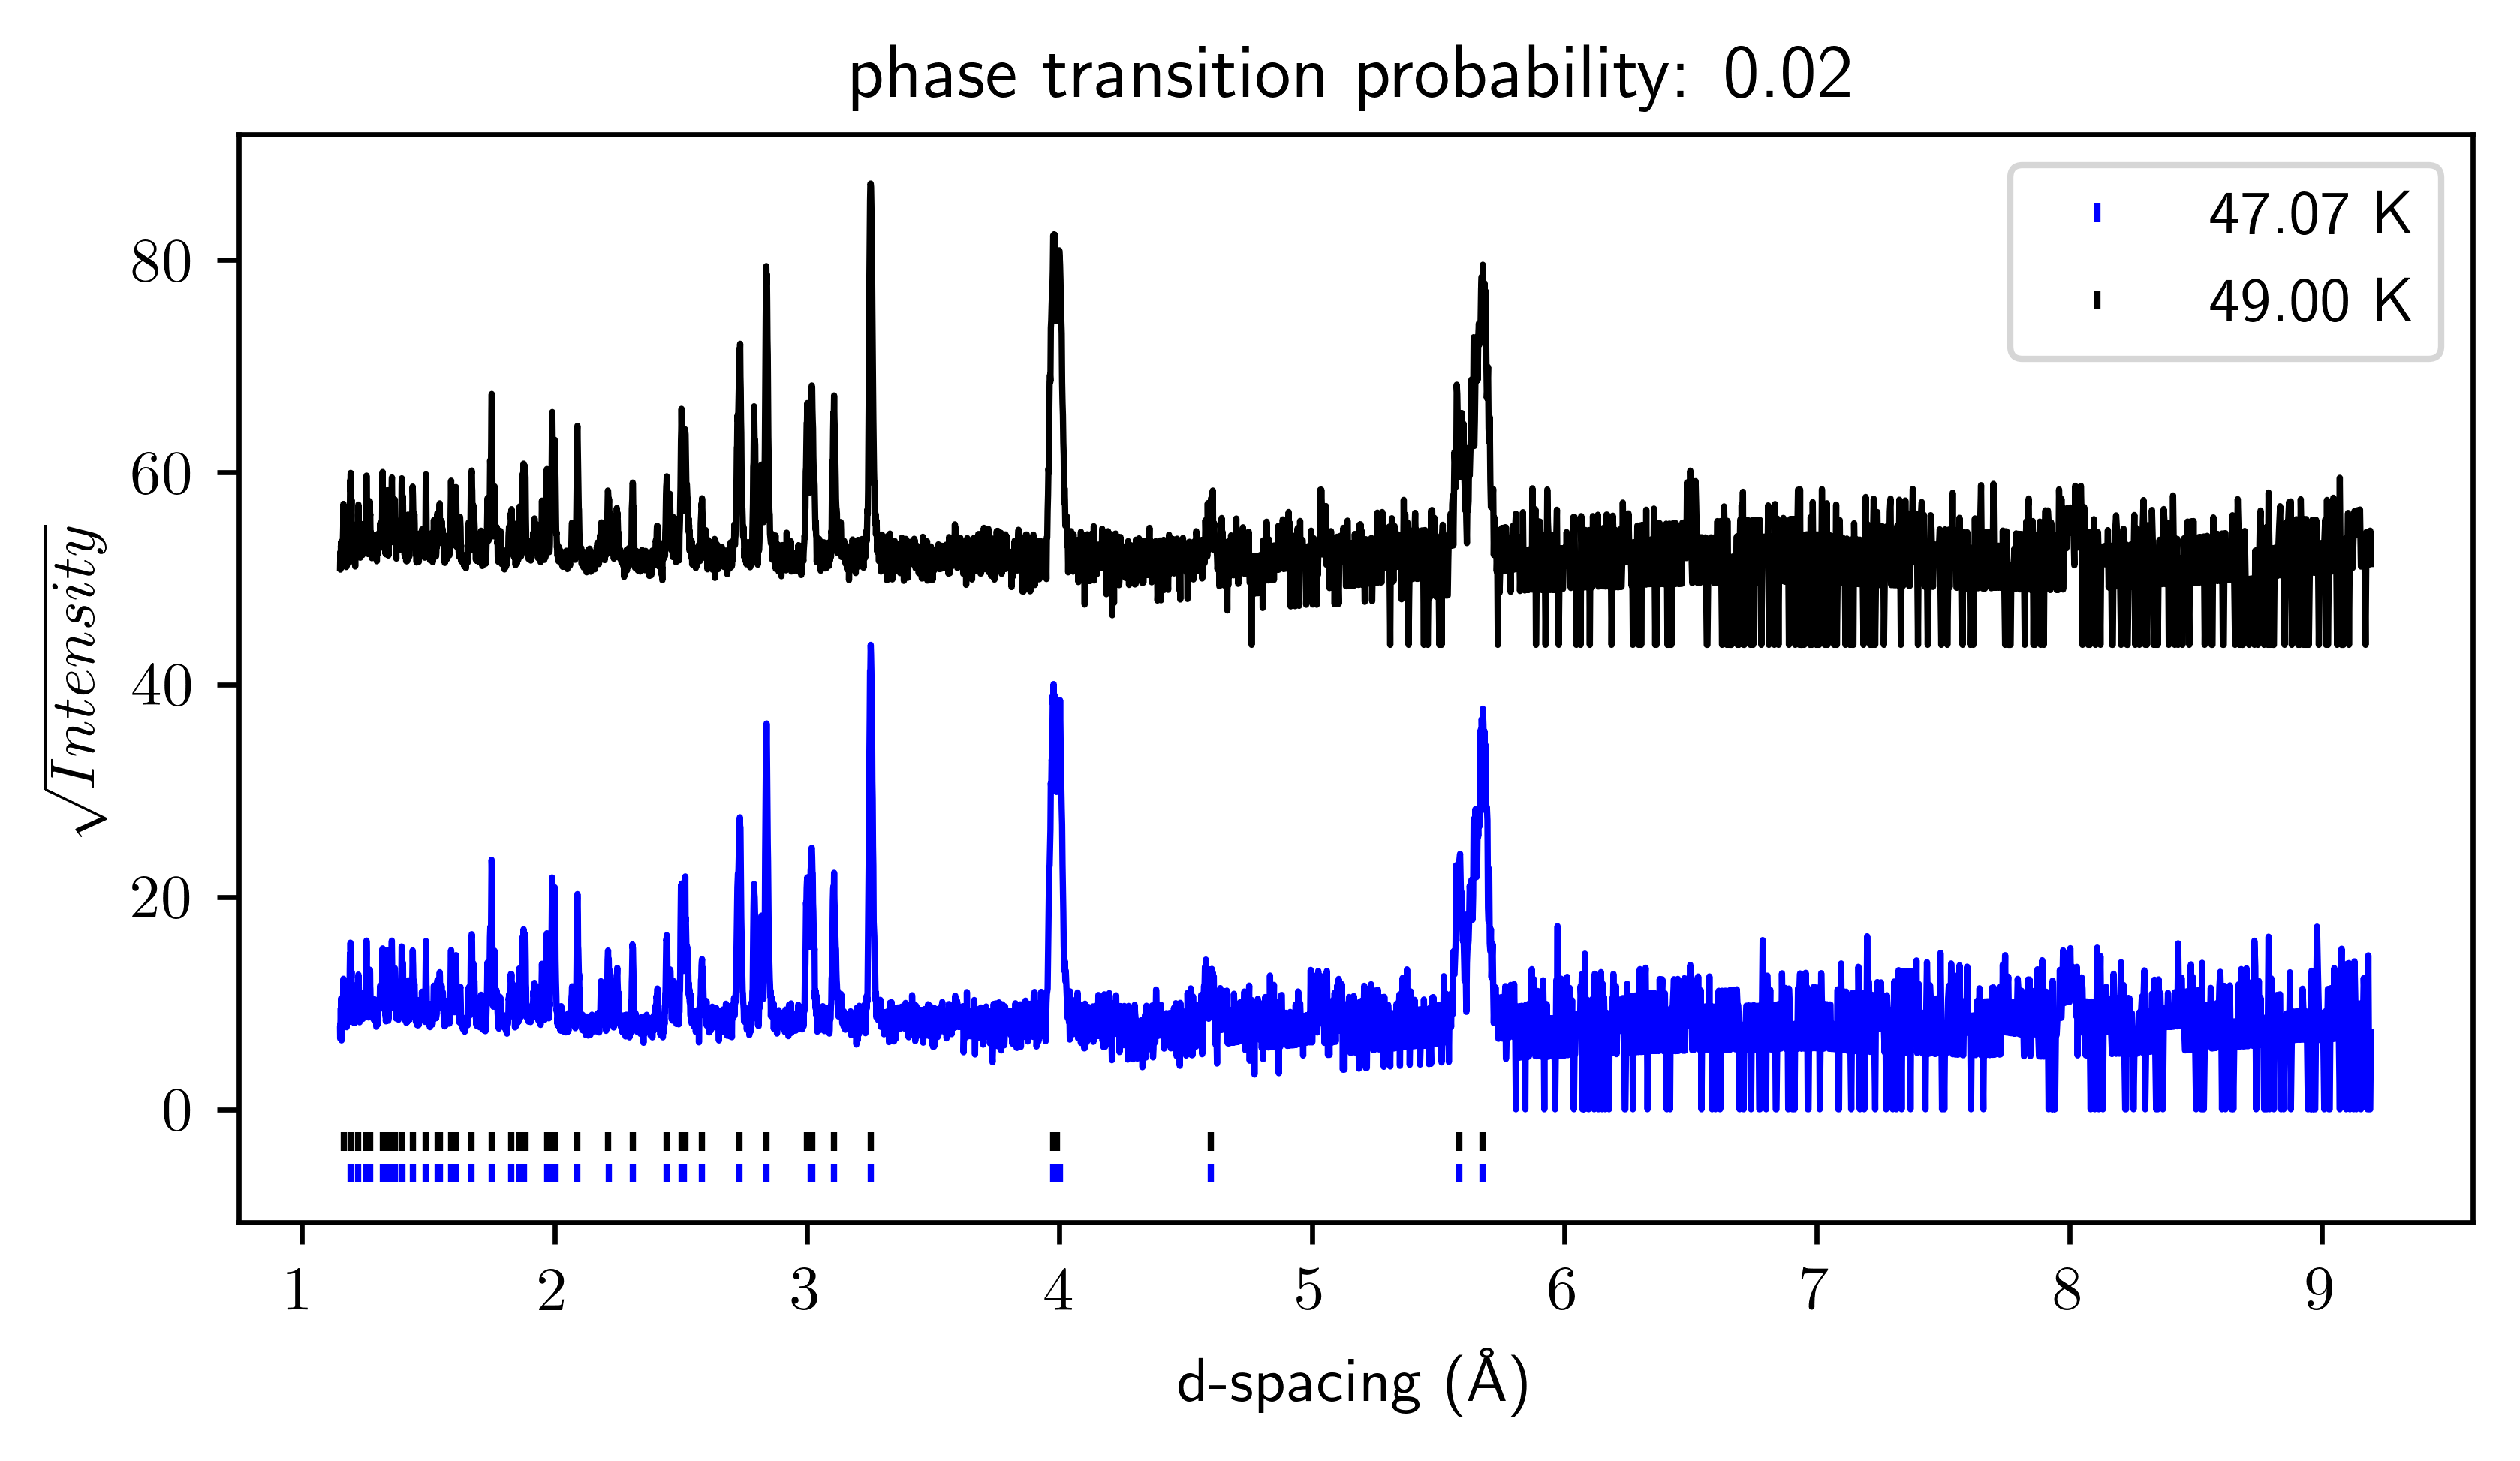

In [252]:
figsize(6.4, 3.2)
temp=48
title = 'Q4/Figs/phasetransitioprobn_%3d_K' %(temp)
cal_likehood_bypeakpos(intsy, temps, dd_cs, temp, figtitle = title)

0.13109735309285664

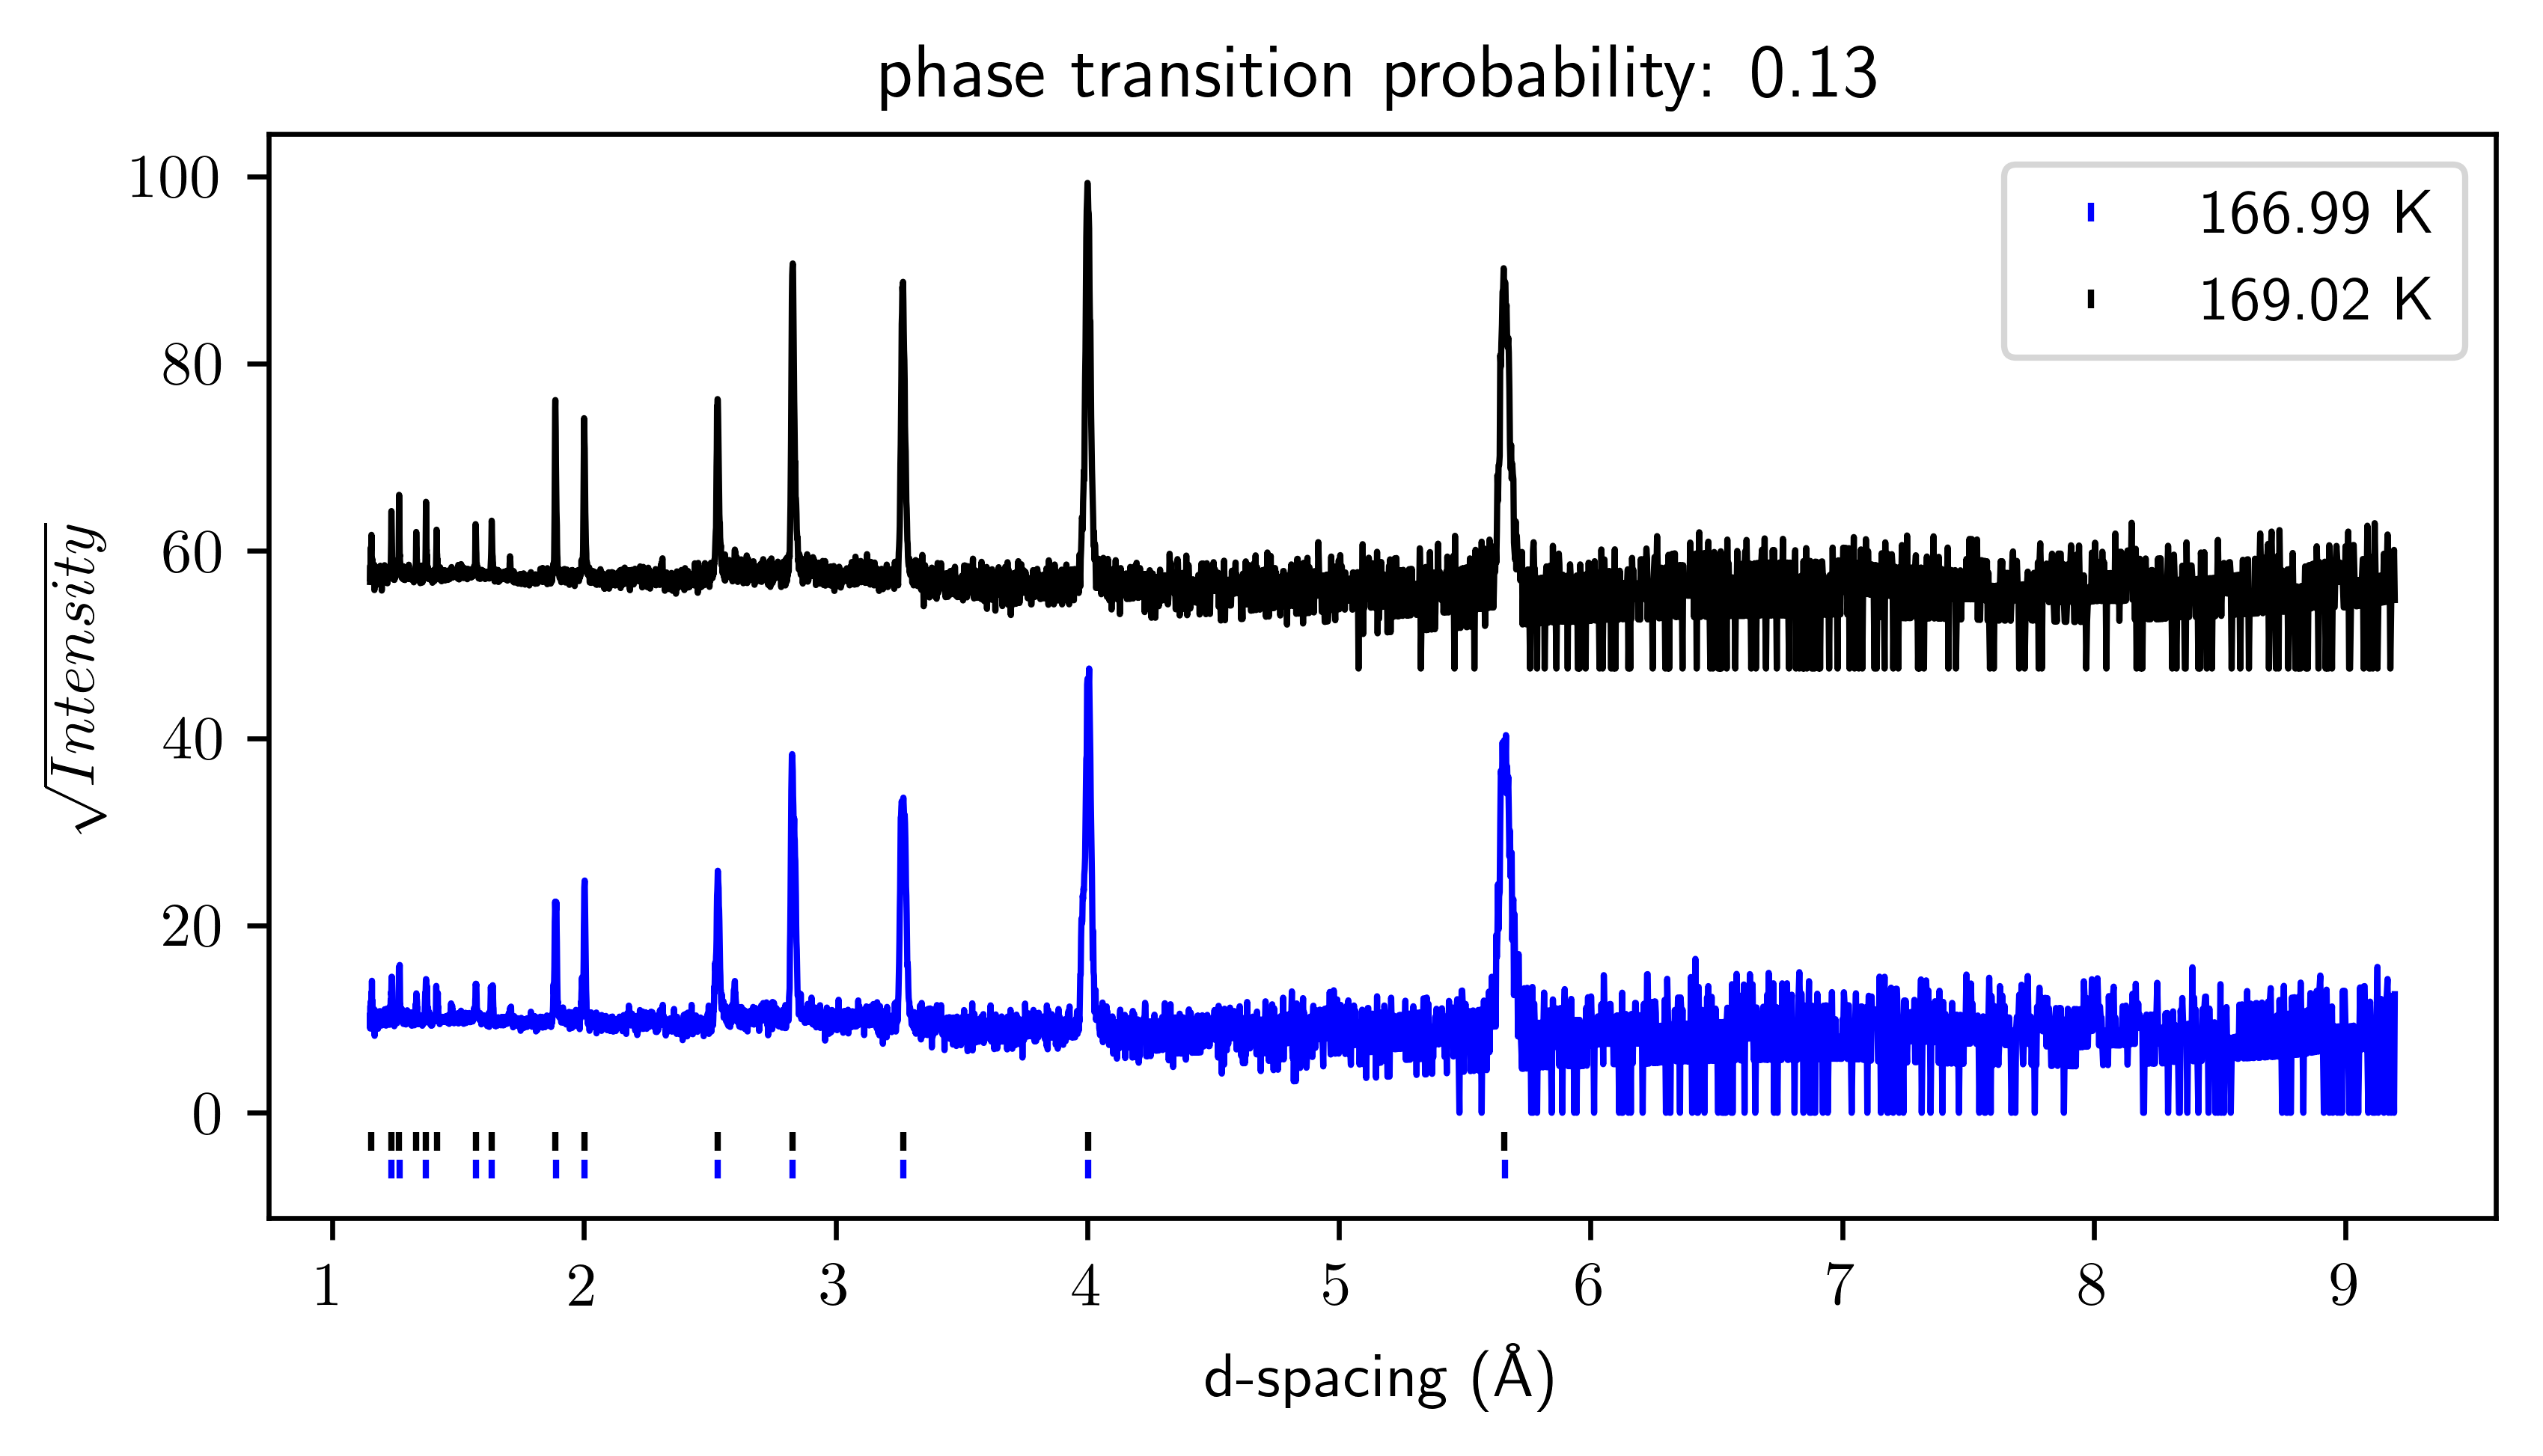

In [253]:
figsize(6.4, 3.2)
temp=166
title = 'Q4/Figs/phasetransitioprobn_%3d_K' %(temp)
cal_likehood_bypeakpos(intsy, temps, dd_cs, temp, gamma = 0.05, figtitle = title)

## 4.2 Create peak table for all temperatures, simialr to what was done in Q3.

    two-segement peak finding with modified ricker wavelet, filter the false peak finding by neighboring peak distances and amplitudes.



In [5]:
from numba import jit

@jit
def cal_peaktables_fullT(intsyMap, pars, bin_cs):
    '''
    calculate peak table one by one for all the temperatures.
    '''
    
    npars, nbins = intsyMap.shape
    peaktables = []
    for par in pars:
        _peaktable = find_peaks_flow(intsyMap, pars, bin_cs, par_val=par)
        peaktables.append(_peaktable)
    
    return peaktables
   

def cal_NNpeakdistance_fullT(peaktables):
    '''
    from global peak tables to calculate the NN distance.
    '''
    
    import numpy as np
    
    npeaktables = len(peaktables)
    
    dists = []
    for ii in range(npeaktables-1):
        dist = _cal_distance_2peaktables(peaktables[ii], peaktables[ii+1])
        dists.append(dist)
        
    return np.asarray(dists)


def _cal_distance_2peaktables(peaks0, peaks1):
    '''
    using the peak position information to determine 
    whether there is a phase transition between two temperatures.
    '''
    from scipy.optimize import least_squares
    
    
    peakpos0, n0 = peaks0[:, 0], len(peaks0)
    peakpos1, n1 = peaks1[:, 0], len(peaks1)
    #print(peakpos0, peakpos1, n0, n1)
    if n0>n1:
        dist = _cal_distance_2peakpos(peakpos0, peakpos1)
    else:
        dist = _cal_distance_2peakpos(peakpos1, peakpos0)
    return dist



def cal_likehood_fullT(peaktables, gamma = 0.04):
    '''
    a likehood function to describe the probability of a phase transition happended 
    between the two datasets by comparsion the different core members.
    
    nnpts: neighboring point used to calcuate the signal point above background. 
    gamma, sensitive factor, more sensitive to small changes.
    '''
    import numpy as np
    
    dist = cal_NNpeakdistance_fullT(peaktables)
    xx = dist/gamma
    likehood = np.tanh(xx)    
    
    return likehood


In [214]:
_peaktables = cal_peaktables_fullT(intsy, temps, dd_cs)

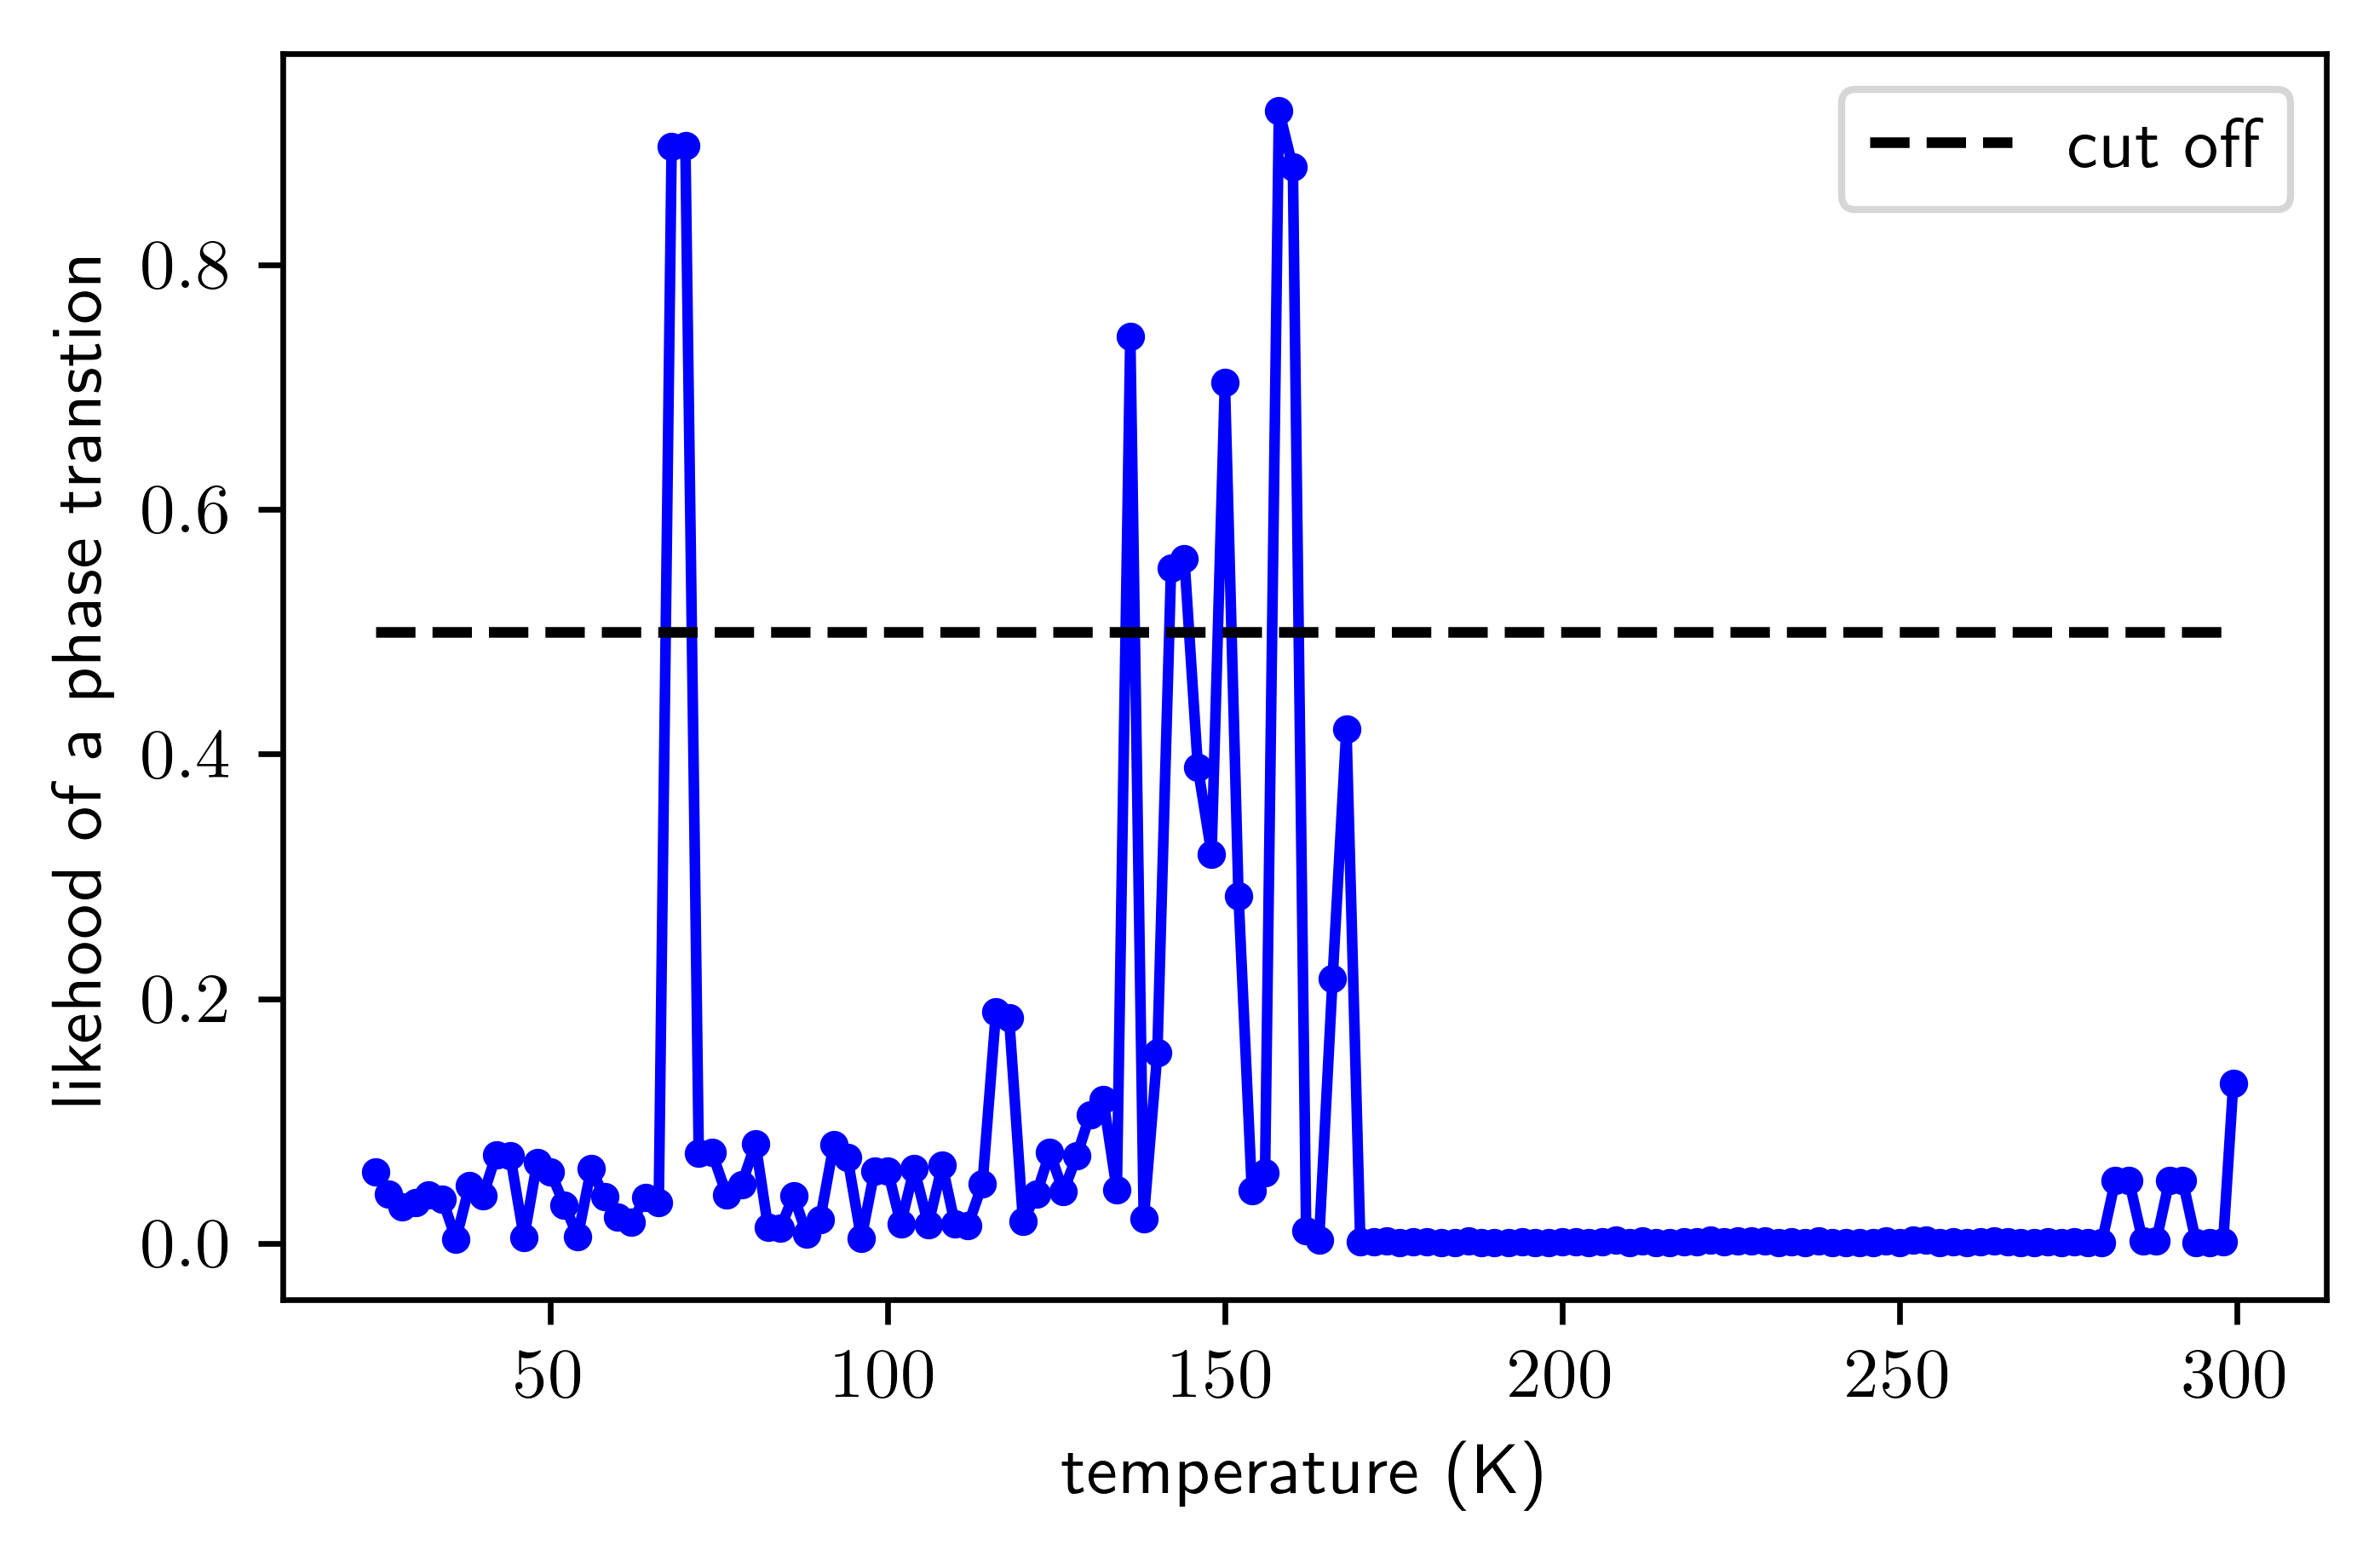

In [226]:
likeh = cal_likehood_fullT(_peaktables, gamma = 0.05)
figsize(4.8, 3.2)
plt.plot(temp_cs, np.asarray(likeh), '.-', color='blue')
plt.plot(temp_cs, np.full(len(temp_cs), 0.5), "--", color='black', label='cut off')
plt.ylabel('likehood of a phase transtion')
plt.xlabel('temperature (K)')
plt.legend()
plt.tight_layout()
#plt.savefig('Q4/Figs/PhaseTransition_Likehood_allT')

In [7]:
# peak table at a single temperature.
%timeit  find_peaks_flow(intsy, temps, dd_cs, par_val=240)

1 loop, best of 3: 319 ms per loop


In [8]:
# peak tables for all temperatures.
%timeit cal_peaktables_fullT(intsy, temps, dd_cs)

1 loop, best of 3: 1min 24s per loop


In [9]:
npeaks=[]
for peaktable in _peaktables:
    npeaks.append(peaktable[:, 0].size)


NameError: name '_peaktables' is not defined

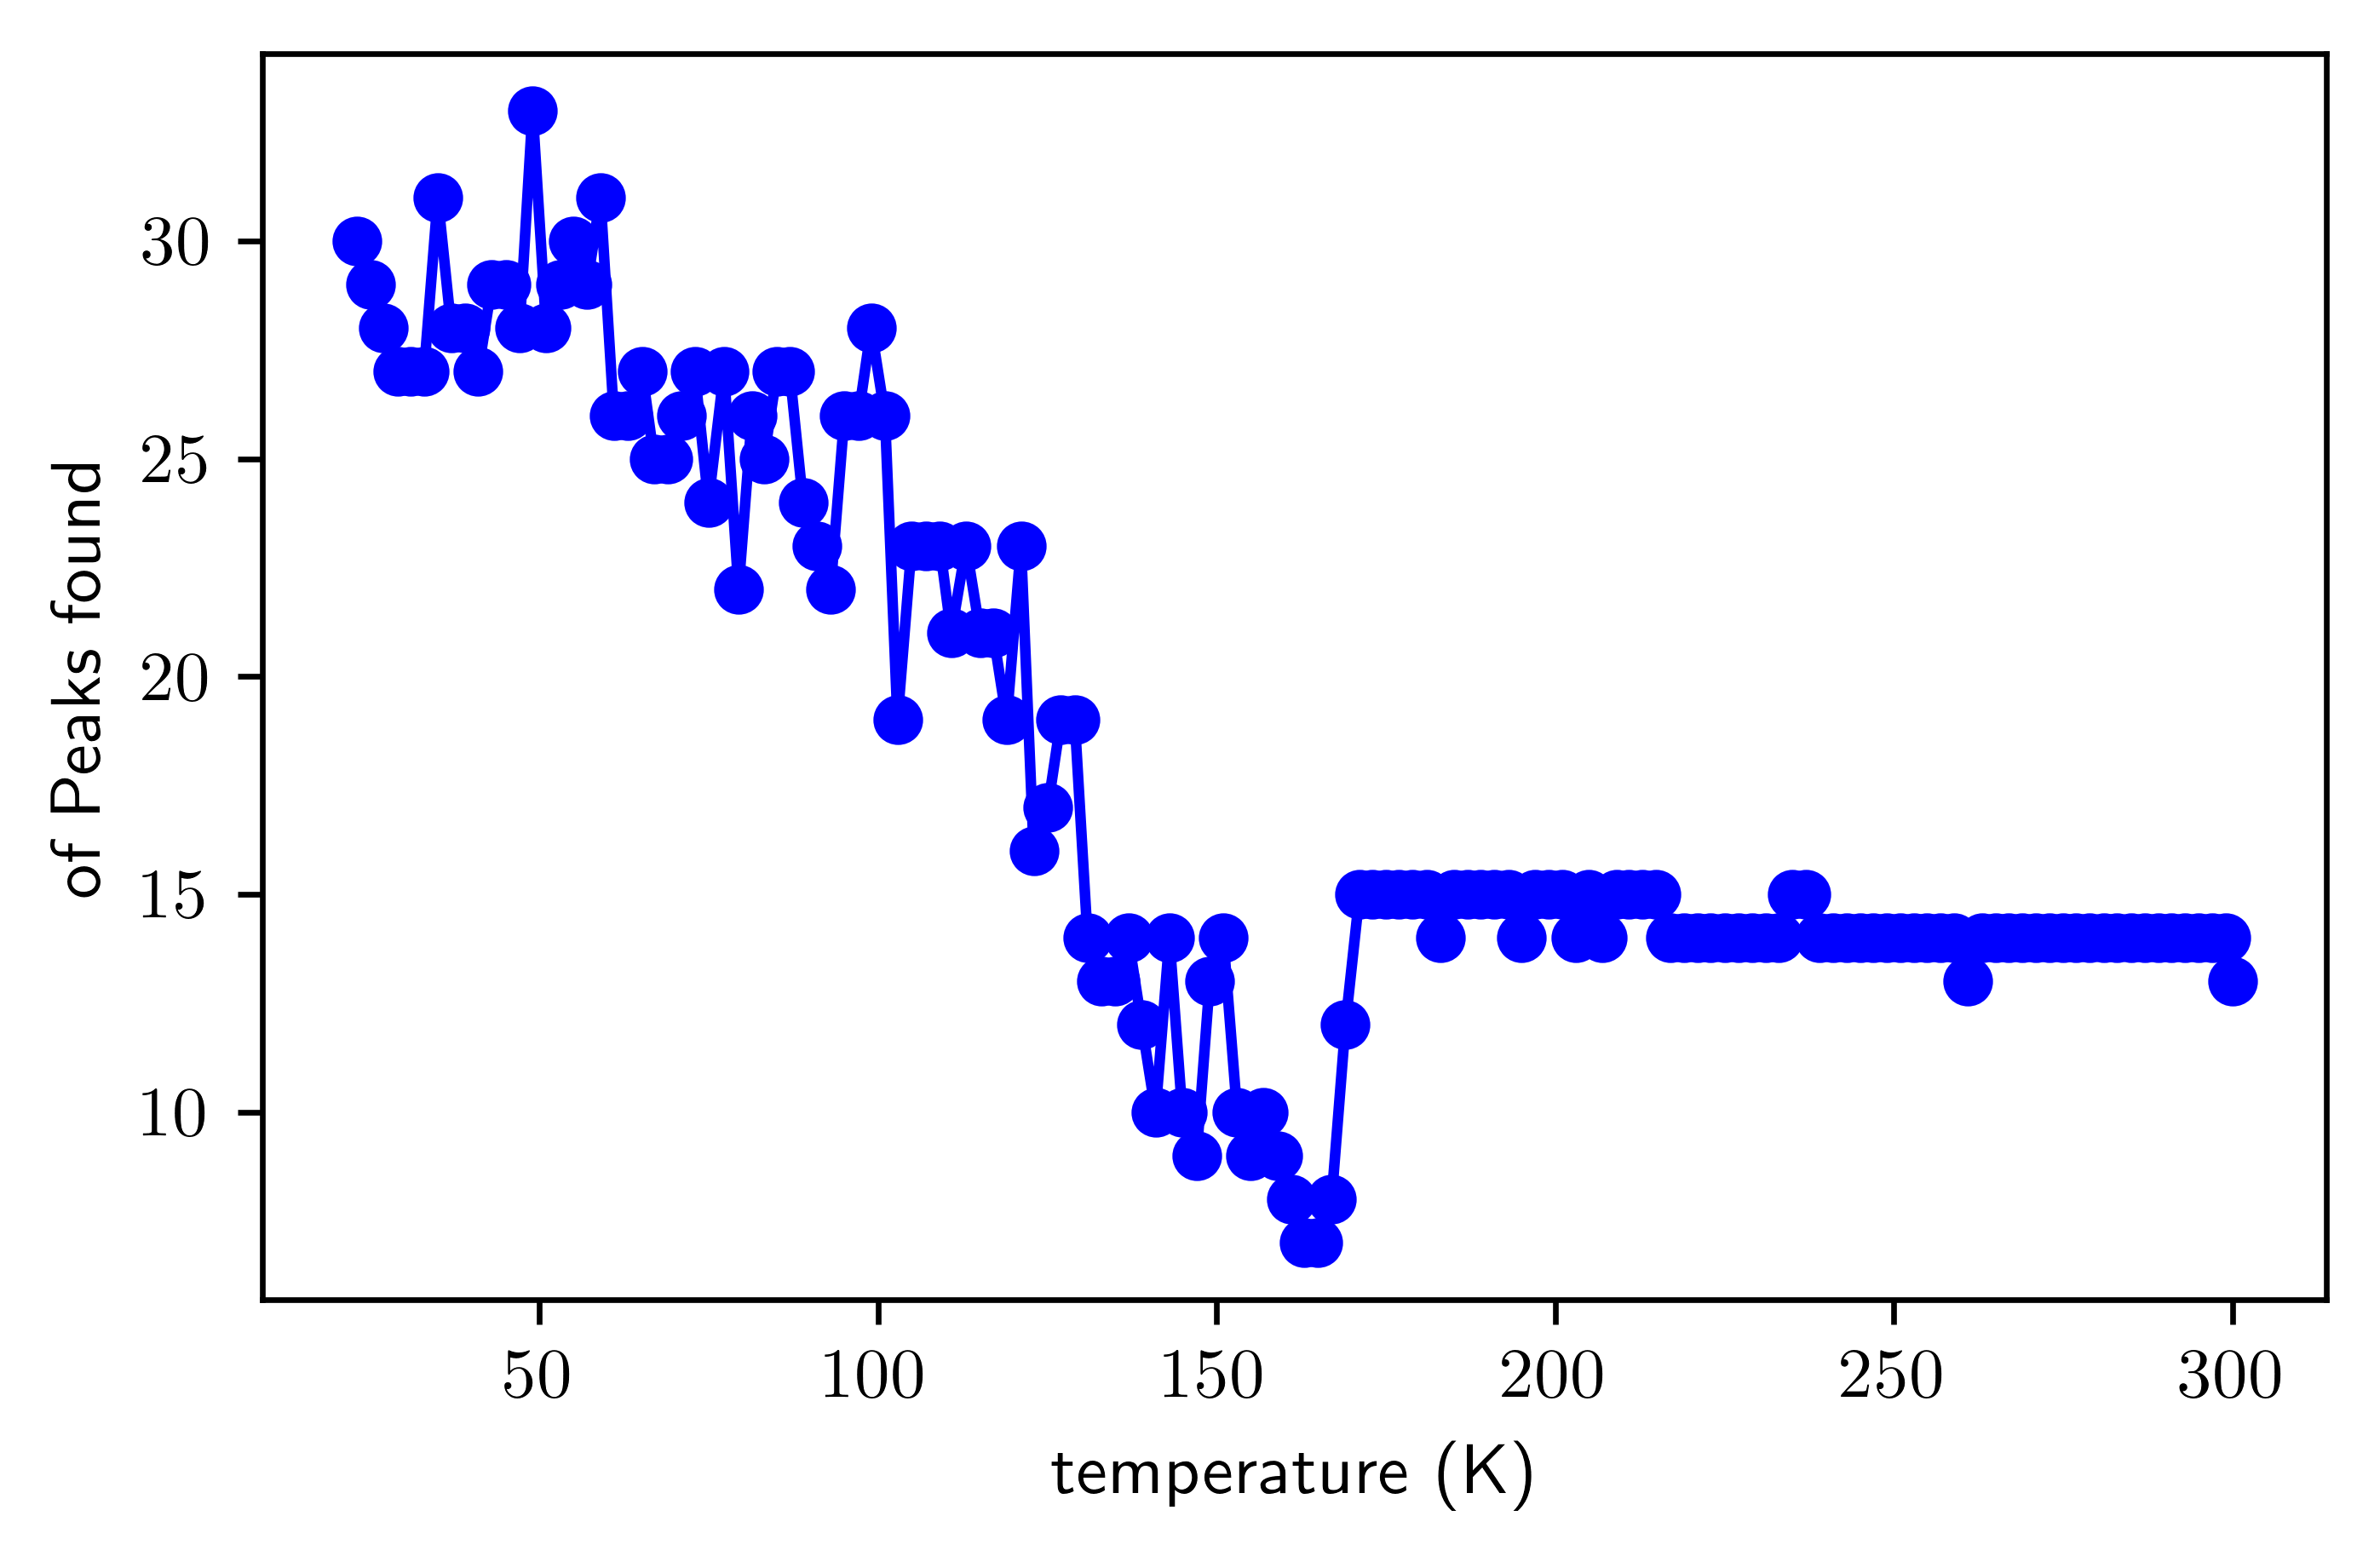

In [212]:
figsize(4.8, 3.2)
plt.plot(temps, npeaks, 'o-', color='b')
plt.xlabel('temperature (K)')
plt.ylabel('# of Peaks found')
plt.tight_layout()
plt.savefig('Q4/Figs/IdentifiedPeakNumbers')

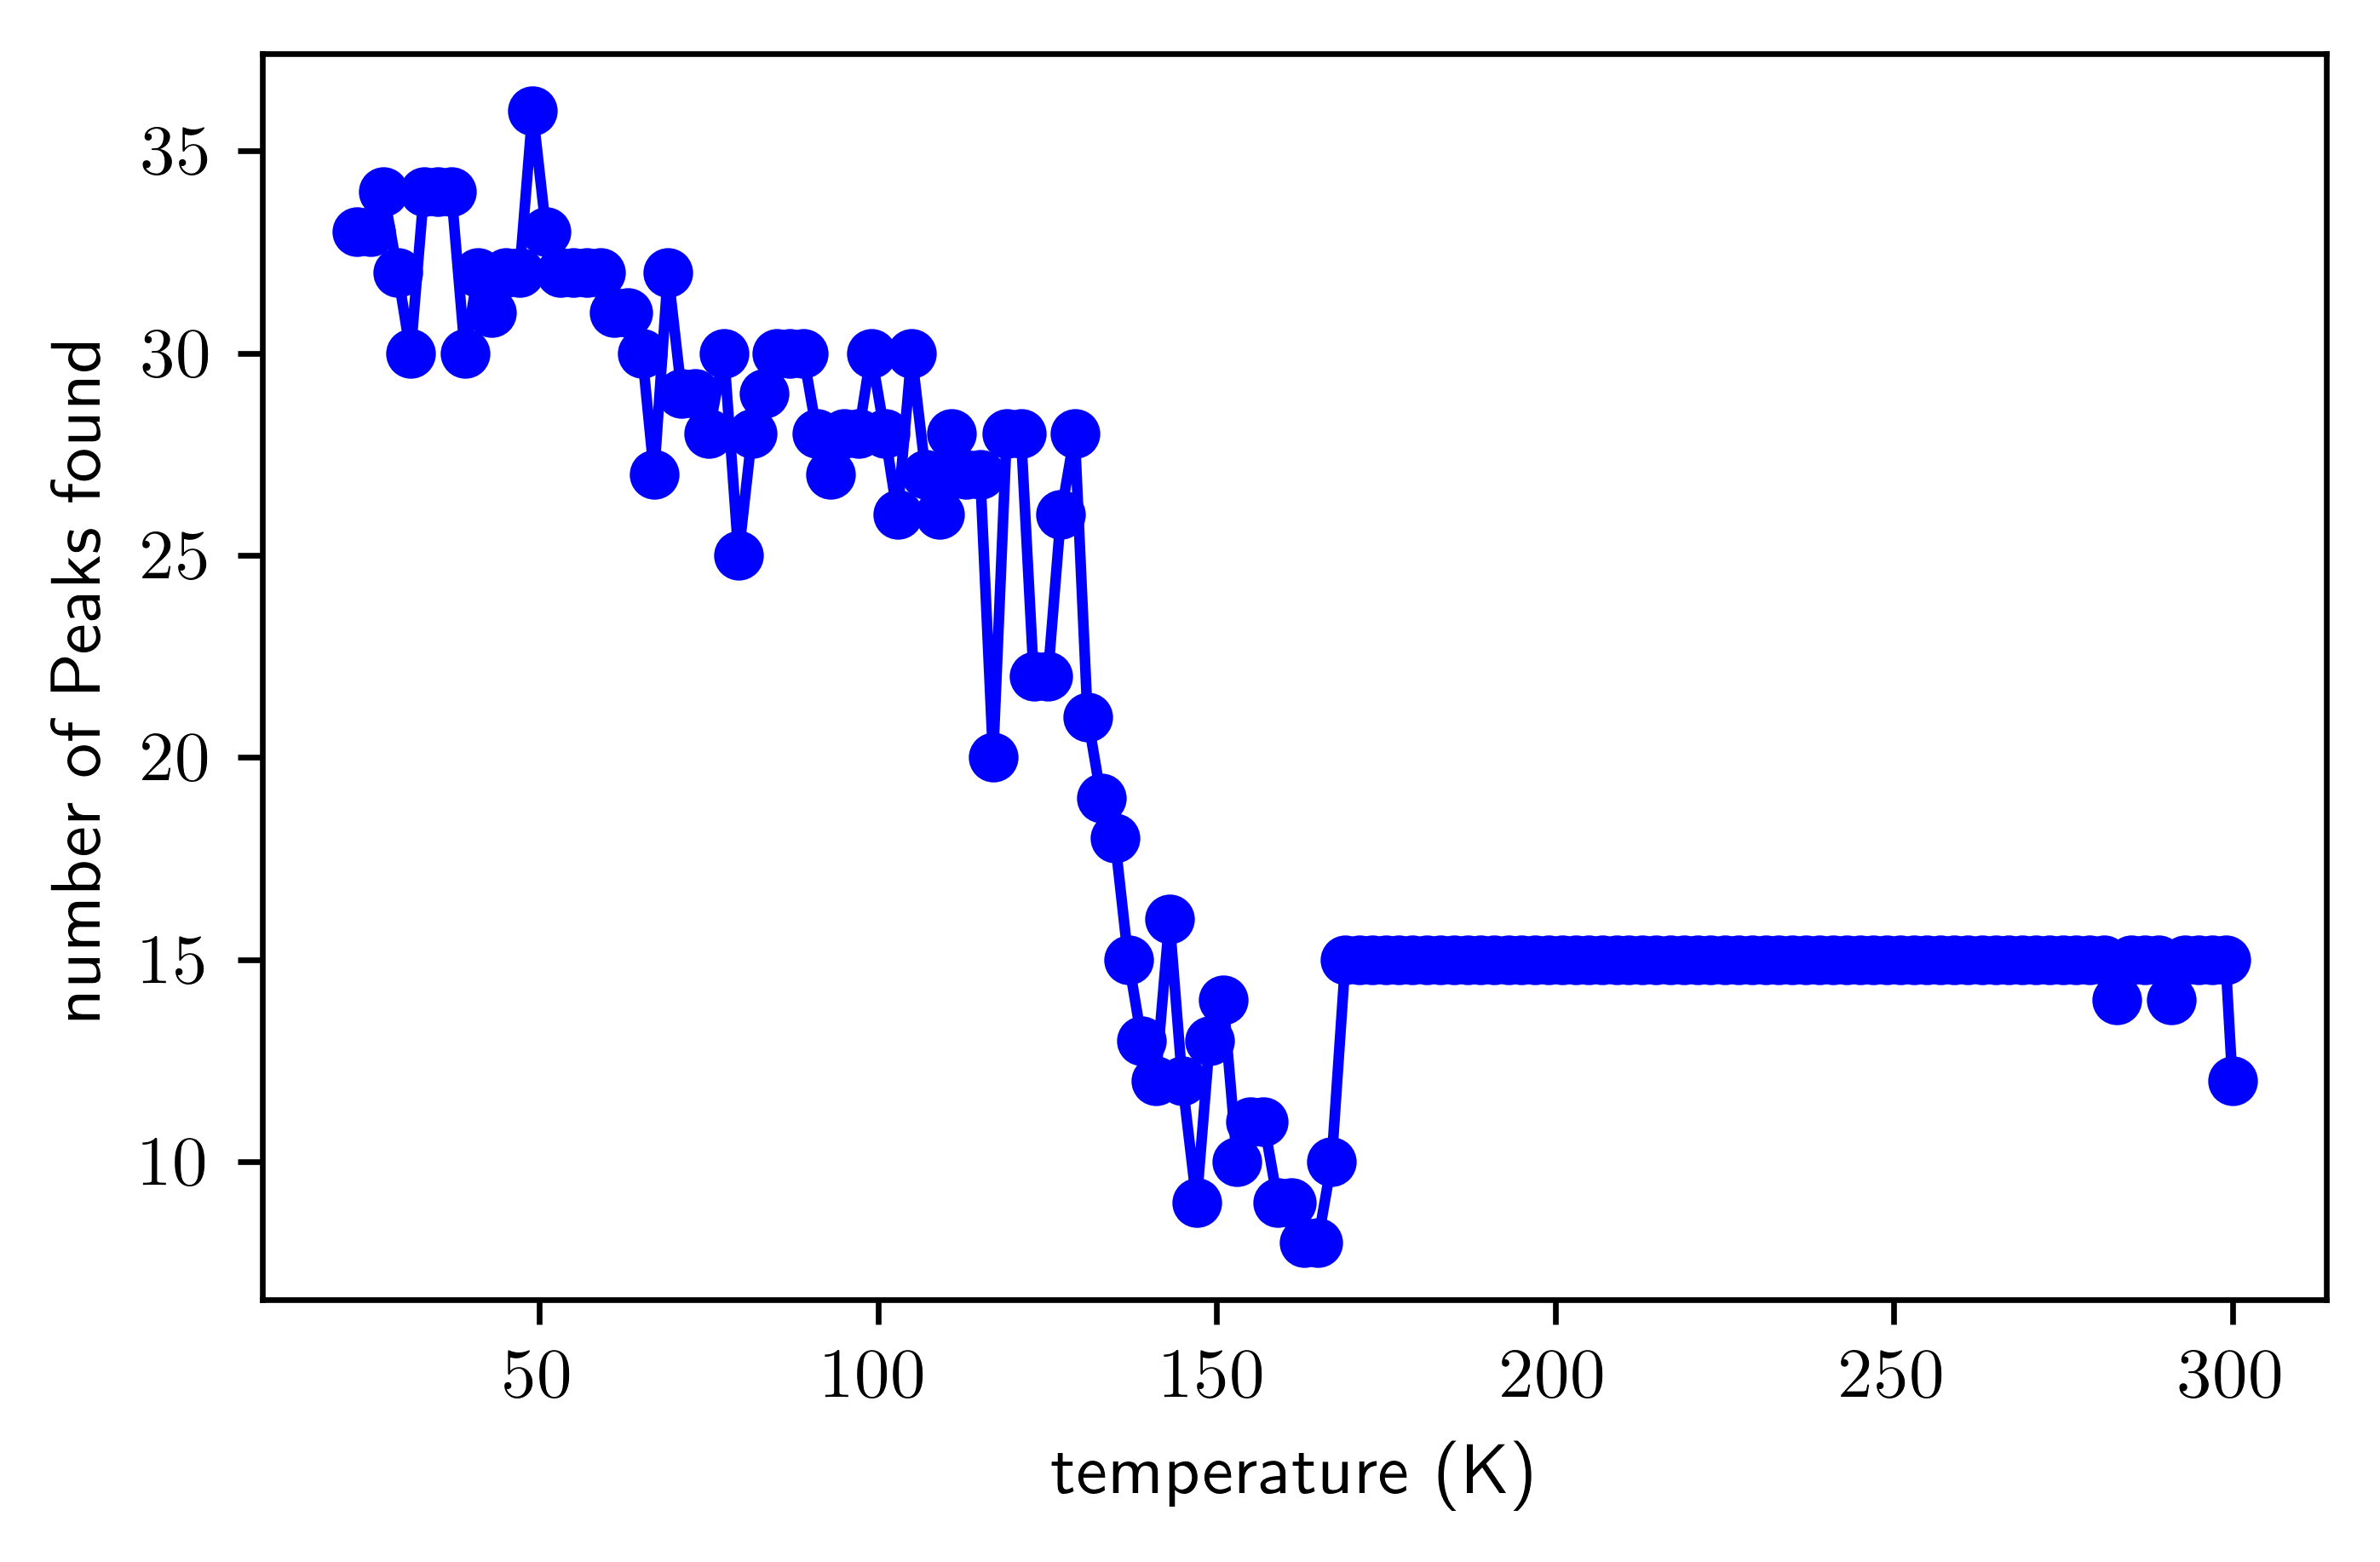

In [254]:
npeaks=[]
for peaktable in _peaktables:
    npeaks.append(peaktable[:, 0].size)


figsize(4.8, 3.2)
plt.plot(temps, npeaks, 'o-', color='b')
plt.xlabel('temperature (K)')
plt.ylabel('number of Peaks found')
plt.tight_layout()
#plt.savefig('Q4/Figs/IdentifiedPeakNumbers')    
    

In [9]:
_peaktables = cal_peaktables_fullT(intsy, _temps, dd_cs)
peaktables = np.vstack((temps, _peaktables))
np.save('Q4/Data/Peaktables_fullT', peaktables)

## 4.2 Speed up for creating peaktables at all temperatures. 
    
    It take about 350 ms to generate a peak table from one temperature. Without MPI, it takes 80 s to create the peaktables for all temperatures (140). In the later case, we can calcualte the wavelet function and save in memeory to use for all temperature to save some time. 
    
        We can also potentially speed up by parallel computation using the MPI for Python package, since the peaktable generation at different temperatures is mutually indpendent. 

### 4.2.1 using multiprocessing 

In [18]:
# aims at finding all peak. update find_peaks_flow, so that it just find peak from a single dataset. 
from numba import jit

#@jit
def parallel_cal_peaktables_fullT(intsyMap, bin_cs):
    '''
    _pars : NXfiled
    '''
    import multiprocessing as mp
    
    pool = mp.Pool(processes=4)
    results = [pool.apply(_find_peaks_flow, args=(data, bin_cs))
              for data in intsyMap]
    
    return results

#@jit
#@dview.parallel(block=True)
def _find_peaks_flow(data, bin_cs, sep = 1/4., min_dis=2, 
                    wavelet=_ricker_asy, bkg=0):
    '''
    Find peaks in a single dataset. 
    
    If a non-zero background term (float) is given, then it assumes that background is 
    predetermined and a background-removed dataset is given. the given value will be 
    the cutoff value.
    
    Otherwise it use 50 percentile value as the background limit. A cutoff value will 
    be calcualted. 
    '''
    from scipy.optimize import least_squares
    
    peakindx = _find_peaks_by_indx(data, sep=sep, min_dis=min_dis, wavelet=wavelet) 
    
    if(bkg != 0):
        _Bkg = []
        cutoff = bkg
    else:
        _Bkg = [np.percentile(data, 50)]
        cutoff = np.percentile(data, 50) + data[data<np.percentile(data, 50)].std()
    
    
    par_ini, bounds= Ini_Mpeaks_pars(data, peakindx, bin_cs, Bkg=_Bkg)
    fit = least_squares(Mpeaks_LS, par_ini, bounds=bounds, 
                        args=(data, peakindx, bin_cs, len(_Bkg)))
    model = Mpeaks_model(fit.x, data, peakindx, bin_cs, NoBkg=len(_Bkg))
    peaktable = gen_peaktable(fit.x, bin_cs, peakindx, NoBkg=len(_Bkg), cutoff=cutoff)
    
    return peaktable

In [176]:
data = intsy[101]
%timeit _find_peaks_flow(data, dd_cs)

1 loop, best of 3: 298 ms per loop


In [178]:
%timeit parallel_cal_peaktables_fullT(intsy, dd_cs)

1 loop, best of 3: 1min 28s per loop


### 4.2.2 using ipyparallel

In [164]:
#@jit
#@dview.parallel(block=True)
def p_find_peaks_flow(data, sep = 1/4., min_dis=2, 
                    wavelet=_ricker_asy, bkg=0):
    '''
    Find peaks in a single dataset. 
    
    If a non-zero background term (float) is given, then it assumes that background is 
    predetermined and a background-removed dataset is given. the given value will be 
    the cutoff value.
    
    Otherwise it use 50 percentile value as the background limit. A cutoff value will 
    be calcualted. 
    '''
    from scipy.optimize import least_squares
    import numpy as np
    #from numpy import percentile
    
    #bin_cs = dd_cs
    peakindx = p_find_peaks_by_indx(data, sep=sep, min_dis=min_dis, wavelet=wavelet) 
    
    if(bkg != 0):
        _Bkg = []
        cutoff = bkg
    else:
        _Bkg = [np.percentile(data, 50)]
        cutoff = np.percentile(data, 50) + data[data<np.percentile(data, 50)].std()
    
    
    peakindx = np.asarray([10, 100, 1000, 3000])
    par_ini, bounds= _Ini_Mpeaks_pars(data, peakindx, dd_cs, Bkg=_Bkg)
    fit = least_squares(_Mpeaks_LS, par_ini, bounds=bounds, 
                        args=(data, peakindx, dd_cs, len(_Bkg)))
    #model = Mpeaks_model(fit.x, data, peakindx, dd_cs, NoBkg=len(_Bkg))
    #peaktable = gen_peaktable(fit.x, dd_cs, peakindx, NoBkg=len(_Bkg), cutoff=cutoff)
    #peaktable = 0
    return par_ini


def p_find_peaks_by_indx(data, sep = 1/4, min_dis=2, wavelet=_ricker_asy):
    '''
        a new version of find_peaks(). only deal a single dataset
        
        1. cut the data into two segements. [0, sep] and [sep, 1]
        2. find peak in each segement and merge the peak together.
        
        3. combined peaks if their distance is less than a min_distance
        '''
    from scipy.signal import find_peaks_cwt
    import numpy as np
    
    
    if sep < 0 or sep > 1:
        raise ValueError("seperation value should be in (0, 1]")
        

    nbins = data.size
    bin_cutoff = int(sep * nbins)
    bin_0, bin_1 = int(bin_cutoff * 1.02), int(bin_cutoff * 0.98)
    data_0, data_1 = data[:bin_0], data[bin_1:]
    
    wws = np.arange(2, 9, 1)
    minlength = 3
    SNr = 1.2
    peakind_0, sep = np.asarray([10, 50, 100, 200, 1000]), 1
    #peakind_0 = find_peaks_cwt(data_0, wws, wavelet=wavelet, 
    #                                     min_length = minlength, min_snr=SNr, noise_perc=10)
    peakind_0 = peakind_0[:-1] if peakind_0[-1] > bin_cutoff else peakind_0
    
    if sep < 1 :
        wws = np.arange(3, 14, 1.5)
        minlength = 3
        SNr = 2.
        peakind_1 = find_peaks_cwt(data_1, wws, wavelet=wavelet, 
                                             min_length = minlength, min_snr=SNr, noise_perc=10)
        # updated to the original bin index
        peakind_1 += bin_1
        peakind_1 = peakind_1[1:] if peakind_1[0] < bin_cutoff else peakind_1

        peakind = np.sort(np.concatenate((peakind_0,peakind_1),0))
    else:
        peakind = peakind_0
    
    peakind = _peak_cleanup_by_distance(peakind, min_dis, nbins)
    
    return peakind


def _Ini_Mpeaks_pars(Intsy, peakind, bin_cs, Bkg=[70, 0], 
                    peakwidth_pars=[1e-3, 2e-4, 6e-4], dtol=6e-4):
    '''
    set up a fitting function including all peaks and a background term
        background: OrderofBkg + 1
            limits can be tuned by experience. [-10, 10] for non-zero order
        resolution: 3, peak_width = C0 + C1*d + C2*d^2, [0, 0.1^n]
        peak amplitude: npeaks, [0, inf]
        peak center : npeaks, [d_c*(1-dtol), d_c*(1+dtol)]
        
        jj: parameter index
    '''
    import numpy as np
    
    npeaks = peakind.size
    NoBkg = len(Bkg)
    nCoef = NoBkg + 3 + npeaks * 2 
    par_ini, low_lmt, high_lmt= np.zeros(nCoef), np.zeros(nCoef), np.zeros(nCoef)
    
    # background
    if NoBkg >0:
        par_ini[:NoBkg] = Bkg
        high_lmt[0] = Intsy.mean()
        if NoBkg > 1:
            low_lmt[1:NoBkg], high_lmt[1:NoBkg] = -10, 10
    
    # peak width, all peak width parameters are positively defined.  
    jj = NoBkg
    par_ini[jj:jj+3] =  peakwidth_pars
    high_lmt[jj:jj+3] = [4e-3, 2e-3, 1e-3]
    
    #peak amplitude, all peak width terms are positively defined.
    jj += 3
    maxbin = bin_cs.size
    for ii in range(0, npeaks):
        _centerbinindx = peakind[ii]
        _low, _high = max(0, _centerbinindx - 4), min(maxbin-1, _centerbinindx + 4)
        _data_max = Intsy[_low:_high].max()
        par_ini[jj]  = _data_max
        high_lmt[jj] = _data_max *1.2
        jj+=1
    
    #peak center
    peaks_ctr = bin_cs[peakind]
    par_ini[jj:jj+npeaks] = peaks_ctr[:]
    low_lmt[jj:jj+npeaks], high_lmt[jj:jj+npeaks] = peaks_ctr[:]*(1-dtol), peaks_ctr[:] * (1+dtol)
    
    bounds =tuple([low_lmt, high_lmt])
    return par_ini, bounds 



def _peak_cleanup_by_distance(peakindx, min_dis, lens=0):
    ''' 
    Define a quick way to remove one of the higher-indexed (index: ii+1) peak if two adjacent 
    peaks are too close to each other,  unless the lower-indexed peak (ii) has been removed 
    and the distance between peaks ii+1 and ii-1 is more thatn min_dis. 
    No more iterations is checked beyond this. 
    There is an option to remove peaks too close to the edges, if lens is defined.
    --
    Input: 
        peak index array.
        minimum index distance.
    Output:
        A new peak index array
    '''
    import numpy as np
    
    if lens > 0:
        peakindx = peakindx[peakindx > min_dis]
        peakindx = peakindx[peakindx < (lens - min_dis)]
    
    npeaks = peakindx.size
    if npeaks > 0:
        unique_peak=[peakindx[0]]
    else:
        return np.asarray([])
    
    if npeaks > 1:
        dist = peakindx[1:] - peakindx[:-1]
        ii=0
        for ii in range(dist.size):
            if dist[ii] >= min_dis:
                unique_peak.append(peakindx[ii+1])
            elif ii>0 & (dist[ii]+dist[ii-1]) >= min_dis:
                unique_peak.append(peakindx[ii+1])

    return np.asarray(unique_peak)


def _Mpeaks_LS(Coef, Intsy, peakind, bin_cs, NoBkg=2):
    '''
    use with scipy.optimize.least_squares
    call Mpeaks_model_1d() to calculate the model results and 
    reutrn the difference between model and data
    '''
    model = Mpeaks_model(Coef, Intsy, peakind, bin_cs, NoBkg)
    mask = model > 0
    diff = model[mask]-Intsy[mask]
    
    return  diff # it expects a 1D array out. 

def _Mpeaks_model(Coef, Intsy, peakind, bin_cs, NoBkg=2):
    '''
    set up a fitting function including all peaks and a background term
        1. background: OrderofBkg + 1
        2. resolution: 3, peak_width = C0 + C1*d + C2*d^2, [0, 0.1^n]
        3. peak amplitude: npeaks, [0, inf]
        4. peak center : npeaks, [d_c*(1-dtol), d_c*(1+dtol)]
    
    return the model results.
    '''
    npeaks = peakind.size
    npts = Intsy.size
    
    # model bkg, polynominal 
    jj = 0
    if NoBkg > 0:
        model = np.full(npts, np.float(Coef[0]))
        jj += 1
        if NoBkg > 1:
            bins_jj = bin_cs.copy() 
            for ii in range(1, NoBkg):
                model += Coef[ii] * bins_jj
                jj += 1
                if(ii+1 < NoBkg): bins_jj*= bin_cs
    else:
        model = np.full(npts, 0.)
        
    _C0, _C1, _C2 = Coef[jj:jj+3]  
    jj += 3
    
    # model peaks, each peak is of shape A0 * exp[ (xx -A1)**2 / A2
    # calcuate for region +/- 12 pixels, which is sufficent.
    # each peak needs extra two parameters
    max_indx = npts -1
    for ii in range(0, npeaks):
        # index range for peak ii
        _centerbinindx = peakind[ii]
        _low, _high = max(0, _centerbinindx - 12), min(max_indx, _centerbinindx + 12)
        #calculate the relative distance to peak center and define a single peak
        _peak_center = Coef[jj+npeaks]
        _sigma = _C0 + _C1 * _peak_center + _C2 * _peak_center**2
        _dd_offset_sq = ((bin_cs[_low:_high] - _peak_center)/_sigma)**2
        _peak = Coef[jj] * np.exp(-_dd_offset_sq)
        model[_low:_high] += _peak 
        jj += 1
    return  model # it expects a 1D array out. 


@jit
def gen_peaktable(fitpars, bin_cs, peakindx, NoBkg=2, cutoff = 0):
    '''
    generate the peaktable from global peak fitting results
    
    peaktable: peak_pos, peak_amplitude,  peak_width
    '''
    npars = len(fitpars) - NoBkg - 3
    npeaks = len(peakindx)
    if npars != npeaks *2:
        raise ValueError("Dimension mismatch between peak parameters and peaks.")
    
    jj = NoBkg+3
    _C0, _C1, _C2 = fitpars[NoBkg:jj]  
    
    peaktable = np.empty([npeaks, 4])
    # [0] pos , [1] amplitude, [2] width, and [3] area
    _pos = fitpars[jj+npeaks:]  # in d value
    _amp = fitpars[jj:jj+npeaks]
    _sigma = _C0 + _C1 * _pos + _C2 * (_pos**2)
    _binsize = bin_cs[1:] - bin_cs[:-1]
    _sigma_in_bin = _sigma / _binsize[peakindx] 
    _area = (2* np.pi)**0.5 * _amp * _sigma_in_bin
    
    peaktable[:, 0] = _pos
    peaktable[:, 1] = _amp
    peaktable[:, 2] = _sigma
    peaktable[:, 3] = _area.flatten()
    
    if cutoff > 0:
        peaktable = peaktable[peaktable[:, 1] > cutoff]
    
    return peaktable






In [111]:
from scipy.optimize import least_squares
from numpy import percentile
from scipy.signal import find_peaks_cwt


In [148]:
import ipyparallel as ipp
rc = ipp.Client()
engines = rc[:]
dview = engines
len(dview)

4

In [166]:
dview.push(dict(_ricker_asy = _ricker_asy, 
                p_find_peaks_by_indx = p_find_peaks_by_indx,
                find_peaks_cwt = find_peaks_cwt, 
                _peak_cleanup_by_distance = _peak_cleanup_by_distance, 
                _Ini_Mpeaks_pars = _Ini_Mpeaks_pars,
                _Mpeaks_LS = _Mpeaks_LS, 
                _Mpeaks_model = _Mpeaks_model, 
                gen_peaktable = gen_peaktable, 
                least_squares = least_squares, 
                percentile = percentile,
                dd_cs = dd_cs,
               ))

<AsyncResult: _push>

In [167]:
results = dview.map_async(p_find_peaks_flow, intsy[:4])
results.wait_interactive()

   0/4 tasks finished after   63 s

KeyboardInterrupt: 

In [ ]:
results.get()

KeyboardInterrupt: 

In [48]:
%timeit dview.map_async(p_find_peaks_flow, intsy[:])

100 loops, best of 3: 5.35 ms per loop


In [55]:
def test(arr, power=2):
    print(arr.shape)
    return arr**power


def test2(arr):
    
    return arr**2

In [61]:
tt2 = np.arange(100).reshape(10, -1)
tt2.shape, len(tt2)

((10, 10), 10)

In [84]:
dview.map_async(test, tt2[:4])

<AsyncMapResult: test>

In [85]:
res.get()

[array([ 0,  1,  4, ..., 49, 64, 81]),
 array([100, 121, 144, ..., 289, 324, 361]),
 array([400, 441, 484, ..., 729, 784, 841]),
 array([ 900,  961, 1024, ..., 1369, 1444, 1521])]